[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0092
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 1.6892e-04
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 9.3579e-05
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 9.1479e-05
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 9.3886e-05
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 9.3486e-05
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 8.9456e-05
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 8.7080e-05
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 8.0383e-05
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 8.6873e-05
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Root Mean Square Error: 1.3445454992429176


<ipython-input-1-e4989f400d19>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


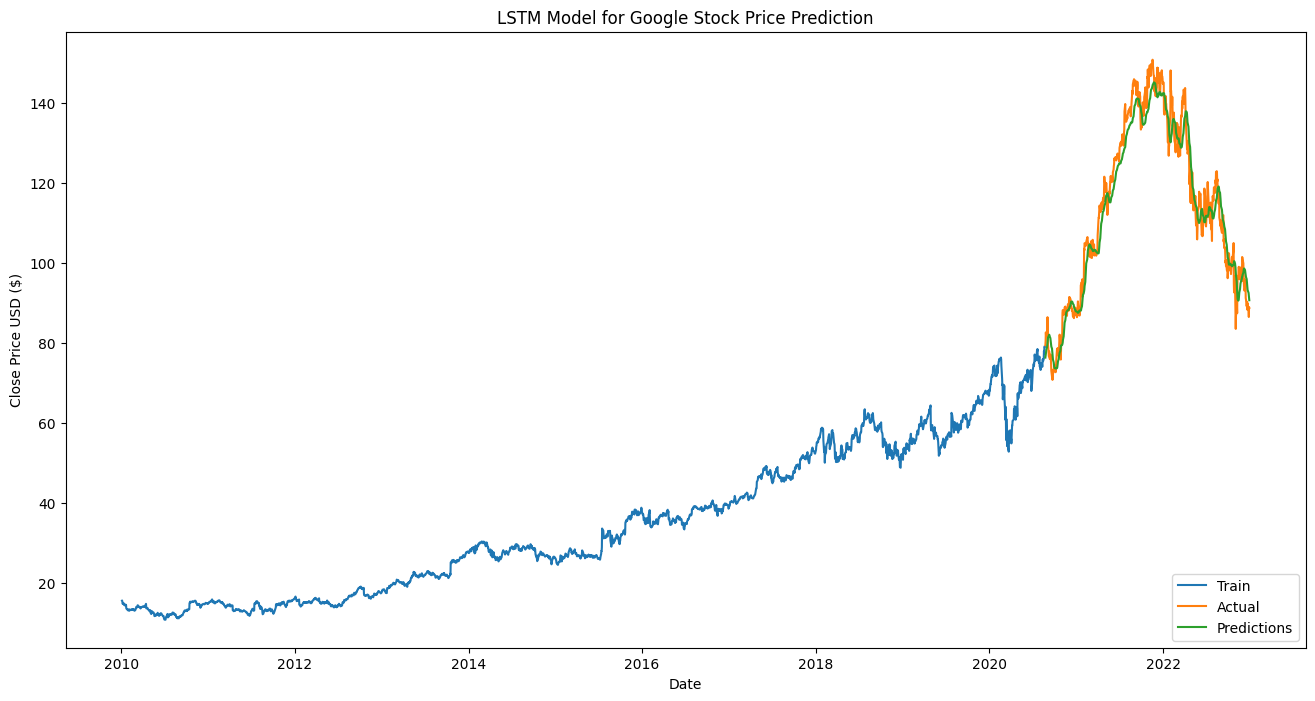

In [1]:
# Step 1: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf

# Step 2: Load Google Stock Data
# Using yfinance to fetch Google's stock price data
df = yf.download('GOOG', start='2010-01-01', end='2023-01-01')

# Step 3: Data Preprocessing
# Select the 'Close' price for prediction
data = df[['Close']]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create a function to prepare the data in sequences
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape the data to be 3D for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Step 4: Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the Model
model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1)

# Step 6: Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Step 7: Evaluate the Model
# Calculate RMSE
rmse = np.sqrt(np.mean(predictions - scaler.inverse_transform(y_test.reshape(-1, 1)))**2)
print(f"Root Mean Square Error: {rmse}")

# Step 8: Visualize the Results
# Ensure 'valid' has the same length as predictions
train = data[:train_size + time_step + 1]
valid = data[train_size + time_step + 1:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('LSTM Model for Google Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()


